In [1]:
# sc.install_pypi_package("pip==22.0.4")
# sc.install_pypi_package("pandas==0.25.1")
# sc.install_pypi_package("Pillow")
# sc.install_pypi_package("pyarrow")

In [28]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle on/off the raw code.">
</form>''')

In [2]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, udf
from pyspark.sql import functions as F

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import warnings
warnings.filterwarnings('ignore')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

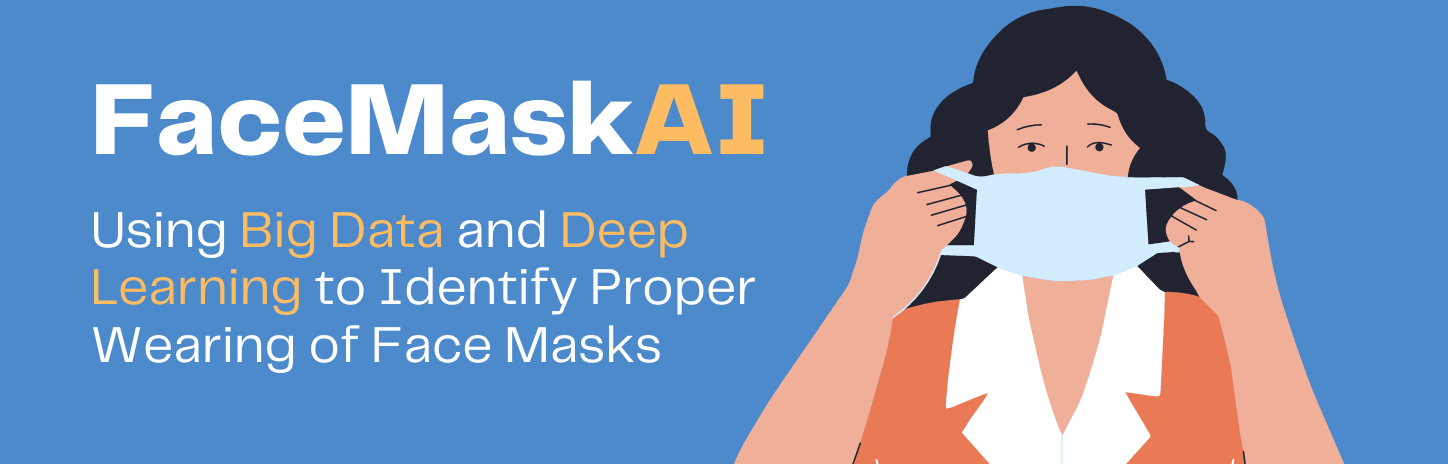

## <font color="4988CD"> I. Executive Summary </font>

As individuals become accustomed to the pandemic and public alert levels decline, more and more people may be seen letting their guard down when it comes to health protocols, such as failing to wear facemasks properly. Needless to say, this increases the danger of COVID transmissions or, in certain situations, a resurgence in cases. However, it is difficult to track and measure whether people are wearing face masks in public on a large scale, let alone enforce mask-wearing norms.

Using the latest tools to process big data consisting of about 84GB in images, combined with the power of deep learning techniques in computer vision, a model that can accurately detect whether a person is WEARING A MASK, HAS AN INCORRECTLY WORN MASK, or HAS NO MASK at all is proposed. The final model has a weight of just 800 KB, which can be easily deployed at scale in any setting or device.

The project demonstrates the usage of Amazon Web Services Elastic MapReduce and Spark's MLlib to do big data classification. Transfer Learning was explored and demonstrated as a pre-trained deep learning model was used to convert the raw data to features that will be used to train the classic ML models. The top model was concluded to be Logistic Regression as it gave the highest accuracy with `88.4%` on the test set, which is higher than the 1.25x PCC's `41.68%`. The model was also able to make predictions for new and unseen images.

Other deep learning models, such as Neural Networks, could be explored to improve the test accuracy of the model. For transfer learning, EfficientNet B0 was utilized, but alternative architectures or state-of-the-art models might also be explored. Other cloud systems and pipelines, such as Dask Tensorflow and Google Cloud Platform, may also be worthwhile to check. Ultimately, it is recommended that the model be refined and implemented for production, particularly in densely crowded areas with high risks of viral transmission, such as schools, airports, churches, and shopping malls.

## <font color="4988CD"> II. Introduction </font>

The Coronavirus disease pandemic of 2019 (**COVID-19**) is currently regarded as one of the most serious worldwide hazards, posing a threat not only to public health and well-being, but also to global economic and social stability. COVID-19 is an infectious disease caused by the SARS-CoV-2 virus. The majority of those infected with the virus will have mild to moderate respiratory symptoms and will recover without the need for medical attention. Some, on the other hand, will become critically unwell and require medical assistance. Serious sickness is more likely to strike the elderly and those with underlying medical conditions such as cardiovascular disease, diabetes, chronic respiratory disease, or cancer. COVID-19 can make anyone sick and cause them to get very ill or die at any age.

The virus spreads through transfer of microscopic liquid particles from infected persons' mouth or nose by coughing, sneezing, speaking, singing, and/or breathing. Larger respiratory droplets to smaller aerosols are among these particles. Coughing into a flexed elbow, staying at least 1 meter away from people, _wearing a well fitted mask_, and washing hands or using an alcohol-based rub on a regular basis are all crucial respiratory etiquette that can help prevent the spread of the virus. Being thoroughly informed on the disease and how it spreads is the best strategy to avoid and slow down transmission.

A number of public health and hygiene measures have been implemented, the most visible of which being the use of face masks. Medical studies on the use of face masks as personal protective equipment (PPE) to prevent SARS-CoV-2 transmission was viewed with caution, and health officials' first recommendations was contradictory. The World Health Organization (WHO) recommendation was created to minimize undue paternalism while yet being comprehensive in its discussion of several medical issues of mask use. It was, however, amended multiple times, moving away from original pronouncements that face masks should not be used by healthy people and toward gradual acceptance of face masks as a beneficial tool in decreasing community transmission. In particular, “…WHO has updated its guidance to advise that to prevent COVID-19 transmission effectively in areas of community transmission, governments should encourage the general public to wear masks in specific situations and settings as part of a comprehensive approach to suppress SARS-CoV-2 transmission".

Masks will remain a crucial strategy to stay safe in specific contexts as long as highly contagious strains of the coronavirus, such as Omicron, continue to prolong the pandemic. The WHO calls on everyone to make wearing a mask a natural part of social interactions. To make masks as effective as possible, they must be used, stored, cleaned, and disposed of properly.

## <font color="4988CD"> III. Motivation of the Study </font>

While many people have resumed pre-pandemic activities, such as going back to work, gyms, and restaurants, there is still concern about reducing COVID measures, even among those who are not at high risk for serious illness. As COVID restrictions are slowly being lifted, it is believed that wearing masks is still necessary in our present reality, especially in the Philippines where herd immunity is still a long way to go.

The proponents believe that there is value in utilizing Artifical Intelligence (AI) to properly monitor wearing of face masks. Proper mask usage in public areas has been shown to be critical in the efforts to reduce infection spread in circumstances such as the COVID-19 pandemic. This can be used to automate checking of compliance to mask-wearing rules in crowded places such as airports and malls. This can also be used by private establishments to detect if employees are maintaining safety standards at work, and can keep track of personnel who do not wear masks and remind them to do so. The project can also help generate data for authorities to determine whether more campaigns are needed to encourage wearing of face masks. And lastly, the model can be incorporated into facial recognition software used in mobile devices, to help improve security features for users.

## <font color="4988CD"> IV. Problem Statement </font>

To help society transition to this new ‘new normal’, the proponents aim to answer the question:

> **Can we train a model to identify if a person is wearing a mask properly using big data and cloud computing  techniques and machine learning?**

## <font color="4988CD"> V. Data Source and Processing </font>

To aid in the success of this project, the proponents opted to process the **Mask Wearing Image** dataset, downloadable from **Kaggle** and sourced from the `Toloka.ai` crowdsourcing service and validated by `TrainingData.ru`.

The dataset consists of over **40,000** images with a total size of **83.8 GB**. 

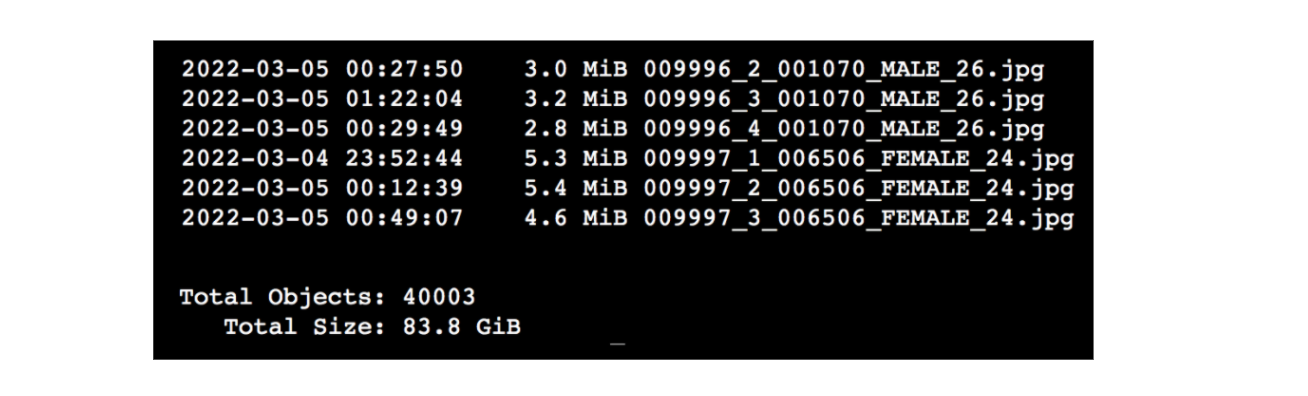

Since the data is quite large, an **Amazon Elastic MapReduce (EMR)** cluster in **Amazon Web Services (AWS)** was used to run the pipeline of the project. AWS is a subsidiary of Amazon that provides on-demand cloud computing platforms. It is the most comprehensive and widely used cloud platform in the world, with over 200 fully featured services available. It is used by millions of clients, including the fastest-growing startups, largest corporations, and top government agencies, to reduce costs, improve agility, and accelerate innovation. AWS is designed to be the most adaptable and secure cloud computing platform on the market today. Its fundamental infrastructure is designed to meet the security needs of the military, global banks, and other high-profile entities. While EMR is a cloud big data platform that uses open-source analytics frameworks like _Apache Spark_ to conduct large-scale distributed data processing jobs, interactive SQL queries, and machine learning (ML) applications. _(Amazon Web Services, 2022)_

The cluster and jupyter notebook was created using EMR 6.5.0 to be able to utilize the latest version of PySpark. PySpark kernel was used in the jupyter notebook to be able to do parallel executions and be able to process big data more efficiently.

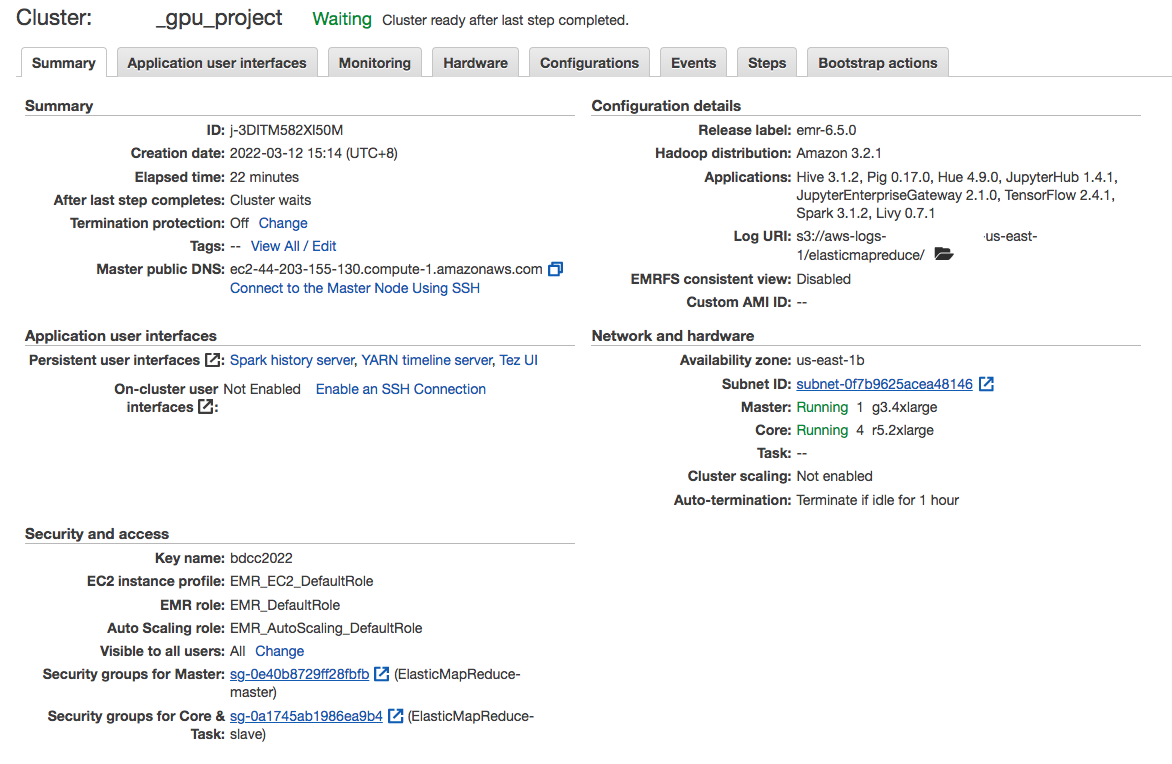

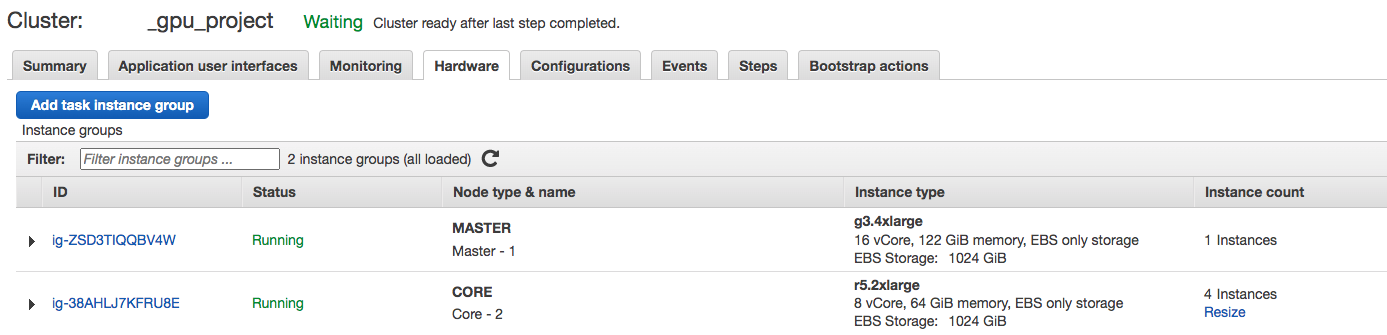

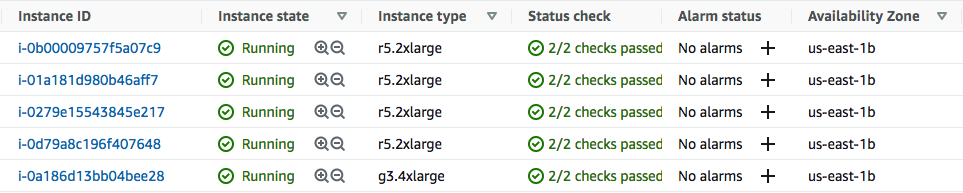

## <font color="4988CD"> VI. Methodology </font>

The approach in tackling the problem of this study is outlined by the methodology.

<center><b>Figure x: Methodology</b></center>

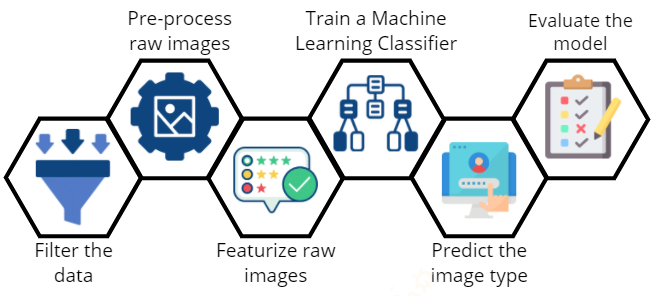

1. **Filtering the data**
    - The dataset consists of images with different file sizes from `0.01 Mb` to `11.11 Mb`
    - Some of the smaller sized images were corrupted. The workaround is to filter the data so as not to capture those images that were corrupted. This will save time by not singling out the corrupted images.
    - In this regard, the images considered to be processed were `1.5 Mb to 5.5 Mb` in size, with a total of `22,034` images and total data size of `59,677.77 MB` or `59.68 Gb`.


2. **Pre-processing raw images**
    - Raw images were vectorized to represent the pixels as vectors.
    - Vectorizing the images to a format that the computer understands.
    
    
3. **Featurize raw images**
    - A pre-trained deep neural network model was used to extract relevant features from images.
    - EfficientNet B0 was used to extract relevant features from the images.
    - This allows the researchers to build classifier models using standard machine learning approaches. 
    
    
4. **Training an ML Classifier**
    - Random Forest Classifier and Logistic Regression was used as the ML classifier models.
    
    
5. **Predicting the image type**
    - After training the model, it was tested to predict unseen data.
    
    
6. **Evaluating the model**
    - The metrics used to evaluate the model was `accuracy`.
    - The model was evaluated on how it performed on unseen data.

### Exploratory Data Analysis

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from cv2 import cv2

In [23]:
df = pd.read_csv('../medical-masks-part1/df.csv')
#dropping images identified as corrupted via manual isolation methods
df = (df[(df['name'] != '000030_1_000030_NONE_29.jpg') &
         (df['name'] != '007790_1_005591_NONE_27.jpg')])

#### Sample Images

Below are the sample images from the dataset. There are 4 images per person, reflecting the 4 possible scenarios:
1. With facemask
2. With facemask but nose is exposed
3. with facemask but nose and mouth are exposed
4. Without facemask

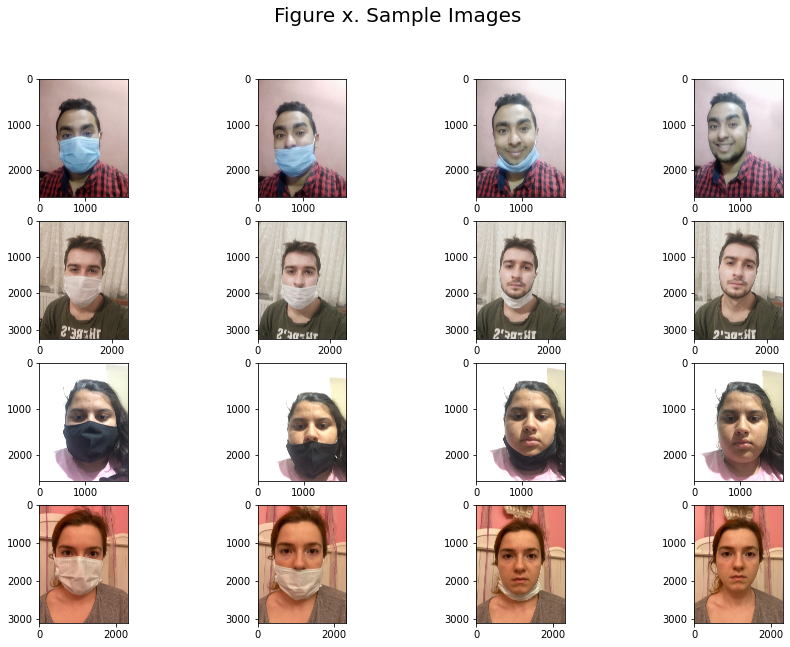

In [6]:
image_path = '../medical-masks-part1/images/'
name_list = df['name'].to_list()

full_path = []
for name in name_list:
    filename = os.path.join(image_path,name)
    full_path.append(filename)


images = []
for i in full_path[:16]:
    img = cv2.imread(i)
    images.append(img)

plt.figure(figsize=(15,10))
plt.suptitle("Figure x. Sample Images", fontsize=20)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.grid(False)
    plt.imshow(images[i][:,:,::-1], cmap=plt.cm.binary)

#### Distribution of the Images According to File Size

The graph in figure x below shows the distribution of images according to file size. It can be inferred that most of the images are composed of file sizes `1.5 Mb to 2 Mb`, which is a standard file size for a standar smart phone photo.

Text(0.5, 1.0, 'Figure x: Distribution of the Images according to file size')

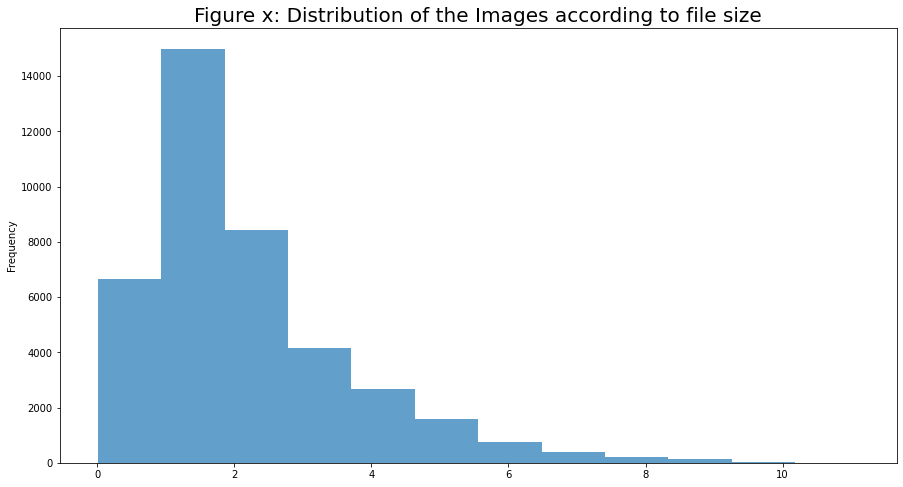

In [24]:
df['size_mb'].plot.hist(bins=12, alpha=0.7, figsize=(15, 8))
plt.title('Figure x: Distribution of the Images according to file size',
          fontsize=20)

#### Distribution of Images According to Scenarios

In the methodology, it was mentioned that the images will be filtered for file sizes `1.5 Mb to 5.5 Mb` so as not to include those corrupted images. The images was also filtered per scenario (this will be further explained in the next section). In figure x below, it shows the distribution of the scenarios 1, 2 and 4. The distribution of the scenario labels are balanced. 

Text(0.5, 1.0, 'Figure x: Distribution of the Images according to Scenario')

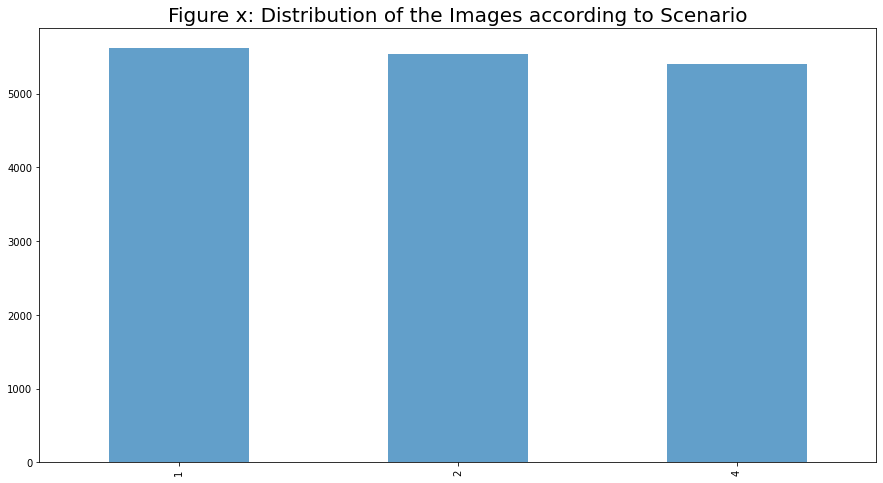

In [26]:
#filtering the dataset
df = df[(df['size_mb'] >  1.5) & (df['size_mb'] <  5.5)]
# Removing scenario 3
df = df[(df['TYPE'] !=  3)]

df['TYPE'].value_counts().plot.bar(alpha=0.7, figsize=(15, 8))
plt.title('Figure x: Distribution of the Images according to Scenario', 
          fontsize=20)

#### Computing for the PCC

How would you know if the classifier is good enough? One way is to calculate the proportional chance criteria (PCC). The PCC also referred to as the proportional by chance accuracy rate computes the highest possible random chance of classifying data without explicit mathematical model other than population counts. As a heuristic or rule of thumb, a classifier machine learning model is considered highly succcesful when the test accuracy exceeds 1.25x the PCC.

In [27]:
PCC = (
        (df[df['TYPE'] == 1]['TYPE'].count()/df['TYPE'].count())**2 +
        (df[df['TYPE'] == 2]['TYPE'].count()/df['TYPE'].count())**2 +
        (df[df['TYPE'] == 4]['TYPE'].count()/df['TYPE'].count())**2
      )

print('The PCC of a random classifier for this data set is:', 
      round(PCC, 4),
      'or', round(PCC*100, 2),'%')
print('The 1.25x PCC of a random classifier for this data set is:', 
      round(1.25*PCC, 4),
      'or', round(1.25*PCC*100, 2),'%')

The PCC of a random classifier for this data set is: 0.3334 or 33.34 %
The 1.25x PCC of a random classifier for this data set is: 0.4168 or 41.68 %


The model should beat the `41.68%` accuracy. This is the baseline accuracy based on the heuristic that a classifier ML model should exceed 1.25x the PCC.

## Filtering the Data

Some of the images, especially the lower sized images were corrupted and thus produces an error while training the model. The workaround was to filter the images according to its file size. In this study, the researchers filtered the images that have file sizes ranging from `1.5 Mb` to `5.5 Mb`. The total size of the filtered images was `59.58 Gb` and the total number of images is `22,034`.

In [3]:
# Load the csv file
df_masks = spark.read.csv('s3://medical-masks-bdcc/df.csv', header=True).toPandas()
df_masks['size_mb'] = df_masks['size_mb'].astype(float)

# Filter out bad images
df_masks = df_masks[(df_masks['size_mb'] >  1.5) & (df_masks['size_mb'] <  5.5)]

# Get list of new database
df_masks['new_path'] = "s3://medical-masks-bdcc/" + df_masks['name'].astype(str)
file_list = df_masks['new_path'].tolist()
file_size = df_masks['size_mb'].sum(axis=0)

print(f'Total size of dataset: {file_size:.4f} MB')
print(f'Total number of images: {len(df_masks)}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total size of dataset: 59677.7661 MB
Total number of images: 22034

The images were then loaded and filtered again according to the classification. Originally, there are `four` classification of the way masks were worn.
- `1` for correctly wearing the facemask
- `2` for improper wearing of facemask - with the nose exposed
- `3` for improper wearing of facemask - with nose and mouth exposed
- `4` for totally not wearing a facemask

The researchers filtered and considered only classifications `1,2, and 4`. The reason for this is that the model is having a hard time distingusing between `scenarios 3 and 4` since both images has the person's nose and mouth exposed. `Scenario 3` is something that is irrelevant and may be treated like `scenario 4`.

With that, the total number of images that the model will process is `18,244`.

In [4]:
# Load the images
url = 's3://medical-masks-bdcc/??????_[1,2,4]_??????*.jpg'

images = (spark.read.format("binaryFile").
          option("pathGlobFilter", "*.jpg").
          load(url))
images = (images.filter(F.col('path').isin(file_list)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
images.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)

In [20]:
images.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

18244

In [21]:
# images.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

##  Featurizing the Images

A pre-trained deep neural network model was used to extract the relevant features from the images. In this study, the researchers used `EfficientNetB0`.

`EfficientNet` is a convolutional neural network architecture and scaling approach that uses a compound coefficient to consistently scale all depth/width/resolution dimensions. Unlike traditional methodology, which arbitrarily scales these elements, the EfficientNet scaling approach evenly adjusts network width, depth, and resolution using a predetermined set of scaling coefficients.

Transfer learning was used by removing the top layer of this network, and used the output as features to train the classic ML models. 

<center><b>Figure x: EfficientNet Building Blocks</b></center>

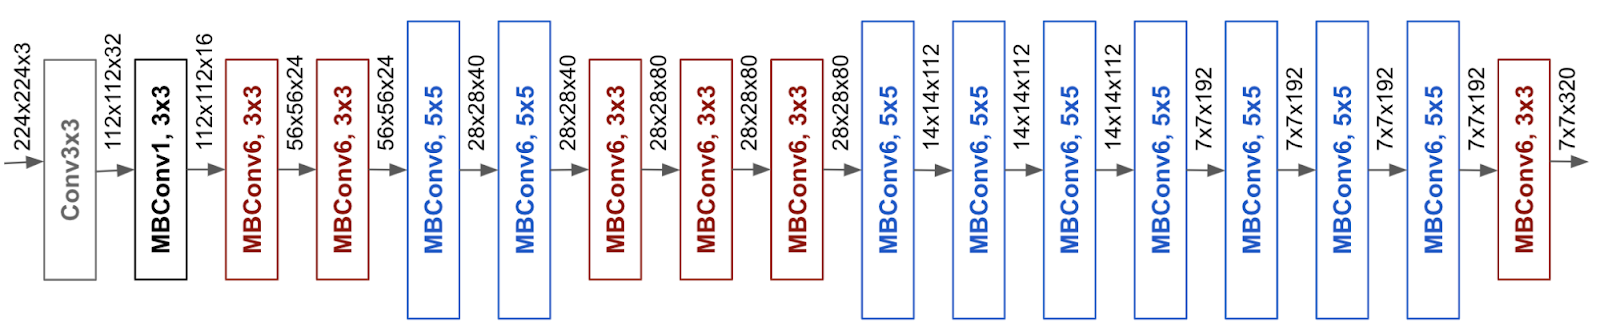

In [5]:
# Load the pre-trained model
model = EfficientNetB0(include_top=False)
model.summary()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [29]:
bc_model_weights = sc.broadcast(model.get_weights())

def model_fn():
    """
    Returns a deep learning model with top layer removed and broadcasted pretrained weights.
    """
    model = EfficientNetB0(weights=None, include_top=False)
    model.set_weights(bc_model_weights.value)
    return model

def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    #   try:
    img = Image.open(io.BytesIO(content)).resize([128, 128])
    arr = img_to_array(img)
    return preprocess_input(arr)


def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
    :param content_series_iter: This argument is an iterator over batches of data, where each batch 
    is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)
        
# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "512")

#images.rdd.getNumPartitions()

# We can now run featurization on our entire Spark DataFrame.
# NOTE: This can take a long time (about 10 minutes) since it applies a large model to the full dataset.
features_df = (images.repartition(images.rdd.getNumPartitions()*4).
               select(col("path"), featurize_udf("content").
                      alias("features")))
# features_df.show(5)

features_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

In [12]:
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

# Create final dataframe
df = (features_df.
      withColumn('label', F.substring('path', 32, 1).cast('int')).
      withColumn('features', list_to_vector_udf(F.col('features'))))
# df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# Distribution of data per label
df.select('label').groupby('label').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
|label|count|
+-----+-----+
|    1| 5617|
|    4| 5407|
|    2| 5534|
+-----+-----+

In [33]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)

After featurizing the images, the data was split into `75% train` and `25% test`.

In [14]:
# Split the data into train and test
df_train, df_test = df.randomSplit([0.75, 0.25])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Training an ML Classifier

The data was then fed to an ML Classifier. The ML models considered in this study are Random Forest and Logistic Regression. `Cross Validatior` was used for Logistic Regression to do grid search within k-fold cross-validation to find the optimal hyperparameter settings that generates the best model for the data.

The researchers tried to do cross validation for the random forest classifier, but unfortunately the run time was too long that the IAM account automatically logs out and terminates the notebook after 12 hours. With limited resources, the researchers couldn't do a rerun of the cross validation. Instead, manual tweaking of the hyper parameters was done.



### Modelling using Logistic Regression

First is to load the ML model and cross validator using Spark's MLlib. With Logistic Regression, it is a straight-forward approach of importing the Logistic Regression model from `pyspark.ml`.

`CrossValidator` starts by partitioning the dataset into folds, which are then utilized as separate training and testing datasets. With `k=3` folds, the CrossValidator will generate 3 (training, test) dataset pairs, each of which uses two-thirds of the data for training and one-thirds for testing. To evaluate a particular `ParamMap`, the CrossValidator computes the average evaluation metric for the 3 models produced by fitting the `Estimator` on the 3 different (training, test) dataset pairs. After identifying the best ParamMap, CrossValidator finally re-fits the Estimator using the best ParamMap and the entire dataset. `ParamGridBuilder` was used to construct a grid of parameters to search over.

In [19]:
# Load the model
lr = LogisticRegression(featuresCol='features',
                        labelCol='label')

# Perform gridsearch to get the best parameter
paramGrid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.001, 0.01, 0.1])
                .build())

cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(metricName=
                                                                "accuracy"),
                    numFolds=3)

cv_trained = (CrossValidatorModel
              .load('s3://medical-masks-bdcc/EffNet_LRCV_mask_trained_124'))

# Get predictions on the train set
df_train_pred = cv_trained.transform(df_train)

# Evaluate the prediction accuracy
print("Train set accuracy = " +
      str(evaluator.evaluate(df_train_pred.select("prediction", "label"))))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Train set accuracy = 0.9971783295711061

In [16]:
# Get the predictions
df_predictions = cv_trained.transform(df_test)

# Evaluate the prediction accuracy
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " +
      str(evaluator.evaluate(df_predictions.select("prediction", "label"))))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test set accuracy = 0.8842079922965816

#### Modelling using Random Forest

`Random forests` are ensembles of `decision trees`. Random forests are one of the most successful machine learning models for classification. They combine many decision trees in order to `reduce the risk of overfitting`. Like decision trees, random forests handle categorical features, extend to the `multiclass classification` setting, do not require feature scaling, and are able to capture non-linearities and feature interactions.

Spark's MLlib supports random forests for binary and multiclass classification, using both continuous and categorical features. Spark's MLlib implements random forests using the existing decision tree implementation. 

Random forests train a set of decision trees separately, so the training can be done in parallel. The algorithm injects randomness into the training process so that each decision tree is a bit different. Combining the predictions from each tree reduces the variance of the predictions, improving the performance on test data.

For Random forest, no c

In [ ]:
from pyspark.ml.classification import RandomForestClassificationModel
rf_trained = RandomForestClassificationModel.load('s3://medical-masks-bdcc/'
                                                  'RF_1,2,4_Mark_09Mar_1300')

df_train_predictions = rf_trained.transform(df_train)

df_predictions = rf_trained.transform(df_test)

# Evaluate the prediction accuracy
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " +
      str(evaluator.evaluate(df_predictions.select("prediction", "label"))))

# Evaluate the prediction accuracy
print("Train set accuracy = " +
      str(evaluator.evaluate(df_train_predictions.select("prediction",
                                                         "label"))))

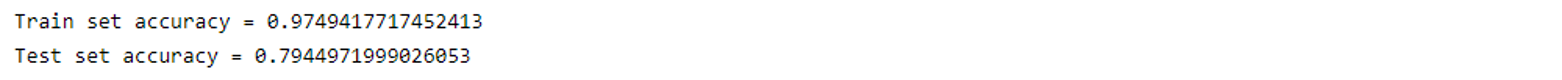

## <font color="4988CD"> VII. Results and Discussion </font>

The researchers used AWS EMR to process and train the big data. Different instances were tried and varies on run times. Some instances couldn't handle training big data and resulted to OOM (Out of Memory) errors.
Some of the instances used in this study are:
- m5.xlarge with 4vCPUs and 16Gb Memory
- m5.4xlarge with 16vCPUs and 64Gb Memory
- m5.8xlarge with 32vCPUs and 128Gb Memory
- r5.xlarge with 4vCPUs and 32Gb Memory
- r5.4xlarge with 16vCPUs and 128Gb Memory
- r5.8xlarge with 32vCPUs and 256b Memory
- g3.4xlarge with 1GPU (8Gb memory), 16vCPUs, and 122Gb Memory

Comparing the performances of the two models used, Logistic Regression performed better with a test accuracy of `88.4%` compared to the test accuracy of Random Forest at `79.5%`.

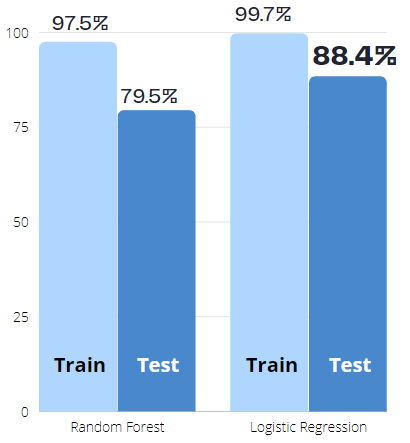

### Trying the model on the researchers photos

The researchers took photos of themselves, imitating scenarios 1,2, and 4. In this test, the model correctly predicted 9 out of 12 sample images. It was 75% correct. It is notable that the model had difficulty classifying Type 2, where the mask is worn incorrectly and covers either the nose or the mouth.

| **Name** 	| **Label** 	| **Prediction** 	|
|---	|---	|---	|
| Norman 	| 4 	| 4 	|
| Kash 	| 4 	| 4 	|
| Mark  	| 4 	| 4 	|
| Pau 	| 2 	| 2 	|
| Pau 	| 4 	| 4 	|
| Kash 	| 2 	| 2 	|
| Mark  	| 1 	| 1 	|
| Mark  	| 2 	| 2 	|
| * _Norman_ 	| _1_ 	| _2_ 	|
| * _Pau_ 	| _1_ 	| _2_ 	|
| Kash 	| 1 	| 1 	|
| * _Norman_ 	| _2_ 	| _4_ 	|

It is still better with the 1.25x PCC of `41.68%`, which means the ML model is better at classifying compared to random chance.

In [47]:
# Load the test images
url = 's3://medical-masks-bdcc/cpt11/??????_[1,2,4]_??????*.jpg'

images = (spark.read.format("binaryFile").
          option("pathGlobFilter", "*.jpg").
          load(url))

# Featurize the data
features_df = (images.repartition(images.rdd.getNumPartitions()*4).
               select(col("path"), featurize_udf("content").
                      alias("features")))

list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

# Create final dataframe
df = (features_df.
      withColumn('label', F.substring('path', 38, 1).cast('int')).
      withColumn('features', list_to_vector_udf(F.col('features'))))

# Distribution per label
#df.select('label').groupby('label').count().show()

# Get predictions
df_predictions = cv_trained.transform(df)

# Get accuracy of model
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + 
      str(evaluator.evaluate(df_predictions.select("prediction", "label"))))

# Results
df_predictions.select('path', 'label', 'prediction').show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------------------------------------------+-----+----------+
|path                                                         |label|prediction|
+-------------------------------------------------------------+-----+----------+
|s3://medical-masks-bdcc/cpt11/xxxxxx_4_xxxxxx_Norman_40.jpg  |4    |4.0       |
|s3://medical-masks-bdcc/cpt11/xxxxxx_4_xxxxxx_kash_39.jpg    |4    |4.0       |
|s3://medical-masks-bdcc/cpt11/xxxxxx_4_xxxxxx_Mark_30.jpg.jpg|4    |4.0       |
|s3://medical-masks-bdcc/cpt11/xxxxxx_2_xxxxxx_Pau_26.jpg     |2    |2.0       |
|s3://medical-masks-bdcc/cpt11/xxxxxx_4_xxxxxx_Pau_26.jpg     |4    |4.0       |
|s3://medical-masks-bdcc/cpt11/xxxxxx_2_xxxxxx_kash_39.jpg    |2    |2.0       |
|s3://medical-masks-bdcc/cpt11/xxxxxx_1_xxxxxx_Mark_30.jpg.jpg|1    |1.0       |
|s3://medical-masks-bdcc/cpt11/xxxxxx_2_xxxxxx_Mark_30.jpg.jpg|2    |2.0       |
|s3://medical-masks-bdcc/cpt11/xxxxxx_1_xxxxxx_Norman_40.jpg  |1    |2.0       |
|s3://medical-masks-bdcc/cpt

## <font color="4988CD"> VIII. Conclusion </font>

As people get accustomed to the pandemic and public alert levels go down, more and more people are relaxing when it comes to health protocols by failing to properly wear facemasks. Needless to say, this poses the risk of more COVID transmissions, or even a resurgence in cases. Yet it is difficult to monitor and measure at scale whether people are wearing facemasks in public, much less enforce adherence to mask-wearing guidelines.

The goal of this study is to train a model to identify if a person is wearing a mask properly using big data and cloud computing techniques and machine learning. With the results from the trained models, it can be concluded that it is possible. Using the latest tools to process Big Data consisting of 84GB in images, combined with the power of deep learning techniques in computer vision, the trained models that can accurately detect whether a person is `WEARING A MASK`, `HAS AN INCORRECTLY WORN MASK`, or `HAS NO MASK` at all.

This study demonstrated the use of AWS EMR and Spark's MLlib as a tool to perform classification on big data. The best model which is Logistic Regression had a test accuracy of `88.4%`, beating the 1.25x PCC of `41.68%`. The model was able to predict from unseen data (images). 

Despite the huge dataset used in training, the final model has a very handy size of only 804 kb, less than 1MB! This should make it quick and easy to implement in places with high risk of viral transmission, such as schools, airports, churches and malls. 

Truly, advancements in computer vision can help solve relevant problems in society. In this study a pre-trained deep learning model was utilized to allow public spaces to enforce health protocols, or help health officials to measure and encourage proper mask wearing. Building data modeling pipelines on countless high resolution images is now possible and cost-effective due to distributed and cloud computing technologies. The resulting models can be deployed by stakeholders with minimal requirements.

## <font color="4988CD"> IX. Limitations and Recommendations </font>

The challenges encountered in this study include cleaning the data using Spark DataFrame, running the model efficiently (Numerous OOM errors were encountered). Due to memory errors, there was a need to upgrade the AWS instances. Upgrading the instances means higher variable cost and with a limited budget of US$ 300 per team member.

Cross validation was also seen as one of the challenges during the implementation of this study. Cross validation takes longer to train. AWS has a federated API Access to AWS Resources for up to 12 hours using IAM Roles. With the training time more than 12 hours, the notebook automatically shutsdown when that limit is reached. The training time for cross validation exceeds 12 hours, and then the notebook shuts down automatically. Rerunning the model was then impossible due to budget constraints.

This study can still be improved by looking at other deep learning models to increase the test accuracy. In this study EfficientNet was used for transfer learning, but other architectures or state-of-the-art models can be considered.

Fine tuning Neural NEt...

Other pipelines and cloud platforms such as Dask Tensorflow and Google Cloud Platform can also be explored.

It is recommended that the model be improved and deployed for production especially on locations that are populated and therefore, high risk of viral transmission, such as schools, airports, churches and malls.

Manny Pac face masks


## <font color="4988CD"> X. Acknowledgements </font>

The output of this study would not have been possible if it weren't for this people:'
- Prof. Christian Alis, for mentoring us and being patient during consultations and providing US$300 of AWS credits.
- Prof. Leodegario Lorenzo II, for helping us troubleshoot our codes when we felt lost and stuck.
- Friends from CPT-10, for giving us other perspectives on approaching image data on the Spark environment.
- Friends from CPT-4

## <font color="4988CD"> XI. References </font>

Martinelli, L. (2021, January 132). Face Masks During the COVID-19 Pandemic: A Simple Protection Tool With Many Meanings. Frontiers. Retrieved March 12, 2022, from https://www.frontiersin.org/articles/10.3389/fpubh.2020.606635/full

Stein, R. (2022, March 9). NPR Cookie Consent and Choices. NPR. Retrieved March 12, 2022, from https://choice.npr.org/index.html?origin=https://www.npr.org/2022/03/09/1085355641/not-everyone-is-ready-to-take-the-leap-and-stop-wearing-face-masks

Watson, S. (2020, April 6). Face Masks for Coronavirus. WebMD. Retrieved March 12, 2022, from https://www.webmd.com/lung/coronavirus-face-masks#1

World Health Organization. (2020, January 10). Coronavirus. Retrieved March 12, 2022, from https://www.who.int/health-topics/coronavirus#tab=tab_1

World Health Organization. (2021, December). When and how to use masks. Retrieved March 12, 2022, from https://www.who.int/emergencies/diseases/novel-coronavirus-2019/advice-for-public/when-and-how-to-use-masks